In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keyring
import os 
import fitz 
import pdfplumber
from langchain.text_splitter import RecursiveCharacterTextSplitter
from collections import defaultdict
from PIL import Image, ImageDraw
from io import BytesIO
import layoutparser as lp
import cv2
import numpy as np
from tqdm import tqdm
from shapely.geometry import box
from shapely.ops import unary_union

In [3]:
pdf_files_path = ".\\Washer_Manuals"
documents = ["k714wm14 service manual.pdf", "technical-manual-w11663204-revb.pdf", "Washing machine Top-loader C series.pdf", "WGG254Z0GB.pdf"]

for idx,filename in enumerate(documents):
    if filename.endswith(".pdf"):
        file_path = os.path.join(pdf_files_path, filename)
        print(f"Document number: {idx}  : ",file_path)
        # do something with the file
        break
    else:
        continue

Document number: 0  :  .\Washer_Manuals\k714wm14 service manual.pdf


In [61]:
def render_pdf_to_images(pdf_path, zoom=2.0):
    doc = fitz.open(pdf_path)
    images = []
    for i, page in enumerate(doc):
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img_data = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append({
            "page_number": i + 1,
            "image": img_data
        })
    return images

def get_pdf_page_pixel_size(pdf_image):
    width, height = pdf_image.size
    return width * height


def detect_image_regions(page_image, buffer=0, min_size=70, max_size = 1000, threshold=240):
    image = np.array(page_image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying blur to reduce fine lines from tables
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_size and h > min_size:  # Skip tiny blocks (Maybe reconsider)
            regions.append([x - buffer, 
                            y - buffer, 
                            x + w + buffer, 
                            y + h + buffer])
            if w * h > max_size:
                regions.pop(-1)  
    return regions


def crop_regions_from_image(page_image, regions, output_dir, page_num):
    os.makedirs(output_dir, exist_ok=True)
    saved_images = []

    for i, coords in enumerate(regions):
        x1, y1, x2, y2 = map(int, coords)
        cropped = page_image.crop((x1, y1, x2, y2))
        save_path = os.path.join(output_dir, f"page_{page_num}_img_{i+1}.png")
        cropped.save(save_path)
        saved_images.append({
            "page": page_num,
            "image_path": save_path,
            "coords": (x1, y1, x2, y2)
        })
    return saved_images



def add_region_to_page(page_image, regions, output_dir, page_num, pdf_path ,color=(0, 255, 0), alpha=50, save=True, verbose=0):
    os.makedirs(output_dir, exist_ok=True)

    # Convert to RGBA to allow transparency
    annotated = page_image.convert("RGBA")
    overlay = Image.new("RGBA", annotated.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    for coords in regions:
        x1, y1, x2, y2 = map(int, coords)
        draw.rectangle([x1, y1, x2, y2], outline=color + (alpha,), fill=color + (alpha,))

    # Combine original image with overlay
    combined = Image.alpha_composite(annotated, overlay)

    if save:
        image_output_dir = os.path.join(output_dir, pdf_path.split("/")[-1].replace(".pdf", ""))
        save_path = os.path.join(image_output_dir, f"page_{page_num:03d}_with_regions_{color}.png")
        combined.convert("RGB").save(save_path)
        if verbose > 0:
            print(f"Saved page {page_num} with highlighted regions to {save_path}")

    return combined


def merge_overlapping_regions(regions, buffer=0):
    """
    Merges overlapping or intersecting regions.

    Args:
        regions (List[List[int]]): List of regions as [x1, y1, x2, y2].
        buffer (int): Optional buffer added to each region before checking overlaps.

    Returns:
        List[List[int]]: Merged list of non-overlapping regions.
    """
    from shapely.geometry import box
    from shapely.ops import unary_union

    # Convert to shapely boxes with optional buffer
    boxes = [box(x1 - buffer, y1 - buffer, x2 + buffer, y2 + buffer) for x1, y1, x2, y2 in regions]

    # Merge all overlapping boxes
    merged = unary_union(boxes)

    # Ensure output is a list of boxes
    if merged.geom_type == 'Polygon':
        merged_boxes = [merged]
    else:
        merged_boxes = list(merged.geoms)

    # Convert back to [x1, y1, x2, y2] format (round to int)
    merged_regions = []
    for b in merged_boxes:
        x1, y1, x2, y2 = b.bounds
        merged_regions.append([int(x1), int(y1), int(x2), int(y2)])

    return merged_regions



# This is the main function to extract images from the PDF
def extract_images_from_pdf(pdf_path:str, output_dir: str, verbose:int =0):
    rendered_pages = render_pdf_to_images(pdf_path)
    all_extracted = []

    for page_idx,page in enumerate(rendered_pages):
        page_num = page["page_number"] 
        image = page["image"]
        if verbose > 0:
            print(f"Processing page {page_num}...")

        # Detecting regions
        regions = detect_image_regions(image , buffer=2, min_size=70, 
                                        max_size=get_pdf_page_pixel_size(image) * 0.99)
        # Creates new regions by merging overlapping regions (this is a fix for cropped images  )
        new_regions = merge_overlapping_regions(regions, buffer=0)

        if verbose > 0:
            print(f"Found {len(new_regions)} image regions on page {page_num}")

        if not new_regions:
            if verbose > 0:
                print(f"No image regions found on page {page_num}")
            continue
        
        # Creates an image directory for each PDF file
        image_output_dir = os.path.join(output_dir, pdf_path.split("/")[-1].replace(".pdf", ""))
        os.makedirs(image_output_dir, exist_ok=True)

        # Showing the pages with the masked regions 
        modified_image = add_region_to_page(image, new_regions, output_dir, page_num, pdf_path, color=(0, 0, 255), alpha=50, save = False)

        # OLD code 
        extracted = crop_regions_from_image(
            image, new_regions, output_dir=image_output_dir, page_num=page_num
        )
        all_extracted.extend(extracted)
    return all_extracted


pdf_files_path = ".\\Washer_Manuals"
documents = ["k714wm14 service manual.pdf", "technical-manual-w11663204-revb.pdf", "Washing machine Top-loader C series.pdf", "WGG254Z0GB.pdf"]

for idx,filename in enumerate(documents):
    if filename.endswith(".pdf"):
        file_path = os.path.join(pdf_files_path, filename)
        # print(f"Document number: {idx}  : ",file_path)
        extract_images_from_pdf(file_path, output_dir="Washer_Images", verbose = 0)

pdf_path:  .\Washer_Manuals\WGG254Z0GB.pdf
Processing page 13...


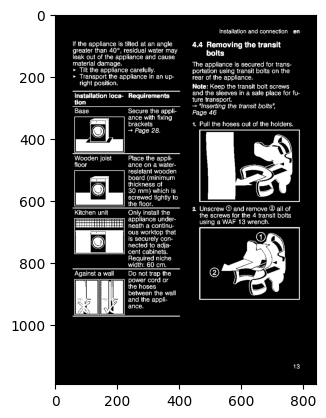

In [ ]:

print("pdf_path: ",file_path)
threshold = 240
page_to_show = 13

rendered_pages = render_pdf_to_images(file_path)

for page_idx,page in enumerate(rendered_pages):
    page_num = page["page_number"]
    page_image = page["image"]

    if page_num == page_to_show:
        print(f"Processing page {page_num}...")
        break


image = np.array(page_image)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Applying blur to reduce fine lines from tables
_, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Show the image with threshold applied

plt.imshow(thresh, cmap='gray')

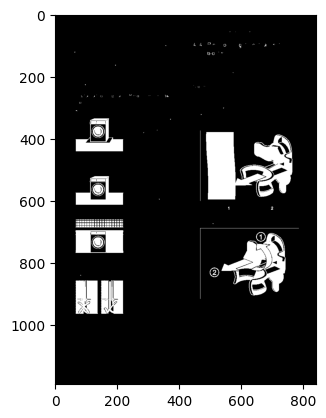

In [ ]:
# cv.drawContours(image, contours, contourIdx, color, thickness, lineType, hierarchy, maxLevel, offset	)

plt.imshow(cv2.drawContours(thresh, contours, -1, (0,200,0), 3), cmap='gray')

In [58]:
min_size = 70
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > min_size and h > min_size:
        print(f"X: {x}, Y: {y}, W: {w}, H: {h} , Area: {w*h}")

X: 144, Y: 853, W: 80, H: 116 , Area: 9280
X: 62, Y: 853, W: 80, H: 116 , Area: 9280
X: 464, Y: 686, W: 324, H: 234 , Area: 75816
X: 62, Y: 657, W: 162, H: 116 , Area: 18792
X: 62, Y: 503, W: 162, H: 116 , Area: 18792
X: 464, Y: 372, W: 324, H: 233 , Area: 75492
X: 62, Y: 330, W: 162, H: 116 , Area: 18792


![page_013_with_regions_(0, 0, 255).png](<attachment:page_013_with_regions_(0, 0, 255).png>)
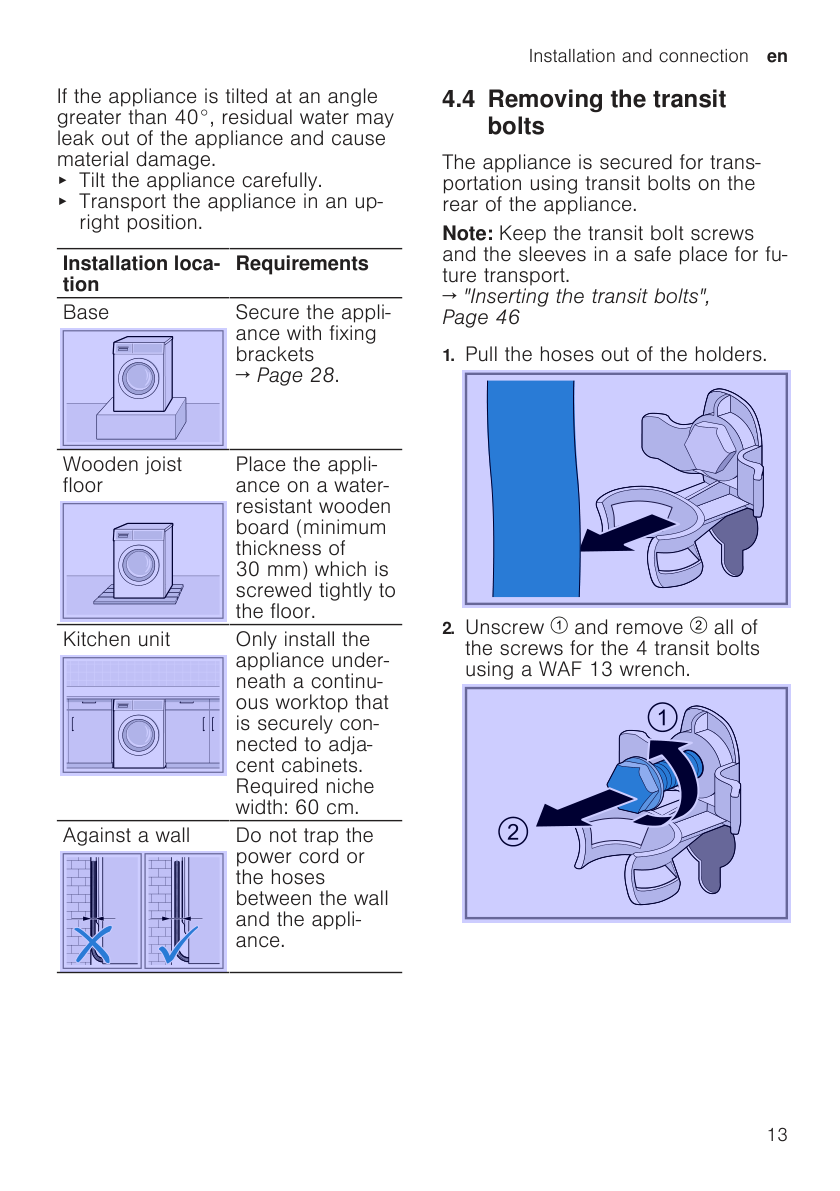